In [19]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [20]:
with open("D:\\Nik\\Projects\\magistrska-naloga\\short-presentation\\preprocessing_example.py", "r") as source:
    ast_node = ast.parse(source.read())

print(ast.dump(ast_node, indent=2))

Module(
  body=[
    Import(
      names=[
        alias(name='math')]),
    FunctionDef(
      name='foo',
      args=arguments(
        posonlyargs=[],
        args=[
          arg(arg='a'),
          arg(arg='b')],
        kwonlyargs=[],
        kw_defaults=[],
        defaults=[]),
      body=[
        Assign(
          targets=[
            Name(id='c', ctx=Store())],
          value=BinOp(
            left=BinOp(
              left=Name(id='a', ctx=Load()),
              op=Pow(),
              right=Constant(value=2)),
            op=Add(),
            right=BinOp(
              left=Name(id='b', ctx=Load()),
              op=Pow(),
              right=Constant(value=2)))),
        Assign(
          targets=[
            Name(id='c', ctx=Store())],
          value=Call(
            func=Attribute(
              value=Name(id='math', ctx=Load()),
              attr='sqrt',
              ctx=Load()),
            args=[
              Name(id='c', ctx=Load())],
            keywords=

In [21]:
def add_ast_node_to_graph(G: nx.DiGraph, node, id=0):
    node_id = id
    G.add_node(node_id, type=node)
    # for fieldname, value in ast.iter_fields(node):
    #     G.add_node(fieldname)
    #     for child in value:
    #         add_ast_node_to_graph(G, child)
    #         G.add_edge(fieldname, child)
        # G.add_node(value)
        # G.add_edge(node, fieldname)
        # G.add_edge(fieldname, value)
    for child in ast.iter_child_nodes(node):
        id += 1
        add_ast_node_to_graph(G, child, id)
        G.add_edge(node_id, id)

In [24]:
def ast_to_graph(node, id=0, skip_nulls=False):
    """
    Traverses an ast, assigns each node a unique id and constructs an nx.DiGraph. 
    
    Keyword arguments:
    - `node` An ast node, aquired through ast.parse().
    - `id` Starting id; all nodes will be numbered in increments of 1, in a depth-first manner.
    - `skip_nulls` Null nodes aren't added to the graph.

    Example use:
    ```
    import ast

    with open("path/to/file.py", "r") as source:
        ast_node = ast.parse(source.read())

    G, _ = ast_to_graph(ast_node)
    ```
    """
    def _add_node_to_graph(node, id: int) -> list:
        node_id = id
        G.add_node(node_id, type=node.__class__.__name__)
        if isinstance(node, ast.AST):
            for name in node._fields:
                try:
                    value = getattr(node, name)
                except AttributeError:
                    continue
                if value is None:
                    continue
                skippable = skip_nulls and not value
                if skippable:
                    continue
                field_id = id + 1
                G.add_node(field_id, type=name)
                G.add_edge(node_id, field_id)
                child_id = field_id + 1
                id = _add_node_to_graph(value, child_id)
                # G.nodes[child_id]["desc"] = G.nodes[child_id]["type"]
                # G.nodes[child_id]["type"] = name
                G.add_edge(field_id, child_id)
            return id
        elif isinstance(node, list):
            # G.nodes[node_id]["desc"] = "[ ]"
            for x in node:
                id += 1
                child_id = id
                id = _add_node_to_graph(x, child_id)
                G.add_edge(node_id, child_id)
            return id
        else:
            G.nodes[node_id]['desc'] = repr(node)
            return id

    if not isinstance(node, ast.AST):
        raise TypeError('expected AST, got %r' % node.__class__.__name__)
    G = nx.DiGraph()
    id = _add_node_to_graph(node, id)
    return G, id

0	Module	
1	body	
2	list	
3	Import	
4	names	
5	list	
6	alias	
7	name	
8	str	'math'
9	FunctionDef	
10	name	
11	str	'foo'
12	args	
13	arguments	
14	posonlyargs	
15	list	
16	args	
17	list	
18	arg	
19	arg	
20	str	'a'
21	arg	
22	arg	
23	str	'b'
24	kwonlyargs	
25	list	
26	kw_defaults	
27	list	
28	defaults	
29	list	
30	body	
31	list	
32	Assign	
33	targets	
34	list	
35	Name	
36	id	
37	str	'c'
38	ctx	
39	Store	
40	value	
41	BinOp	
42	left	
43	BinOp	
44	left	
45	Name	
46	id	
47	str	'a'
48	ctx	
49	Load	
50	op	
51	Pow	
52	right	
53	Constant	
54	value	
55	int	2
56	op	
57	Add	
58	right	
59	BinOp	
60	left	
61	Name	
62	id	
63	str	'b'
64	ctx	
65	Load	
66	op	
67	Pow	
68	right	
69	Constant	
70	value	
71	int	2
72	Assign	
73	targets	
74	list	
75	Name	
76	id	
77	str	'c'
78	ctx	
79	Store	
80	value	
81	Call	
82	func	
83	Attribute	
84	value	
85	Name	
86	id	
87	str	'math'
88	ctx	
89	Load	
90	attr	
91	str	'sqrt'
92	ctx	
93	Load	
94	args	
95	list	
96	Name	
97	id	
98	str	'c'
99	ctx	
100	Load	
101	keywords	
102	lis

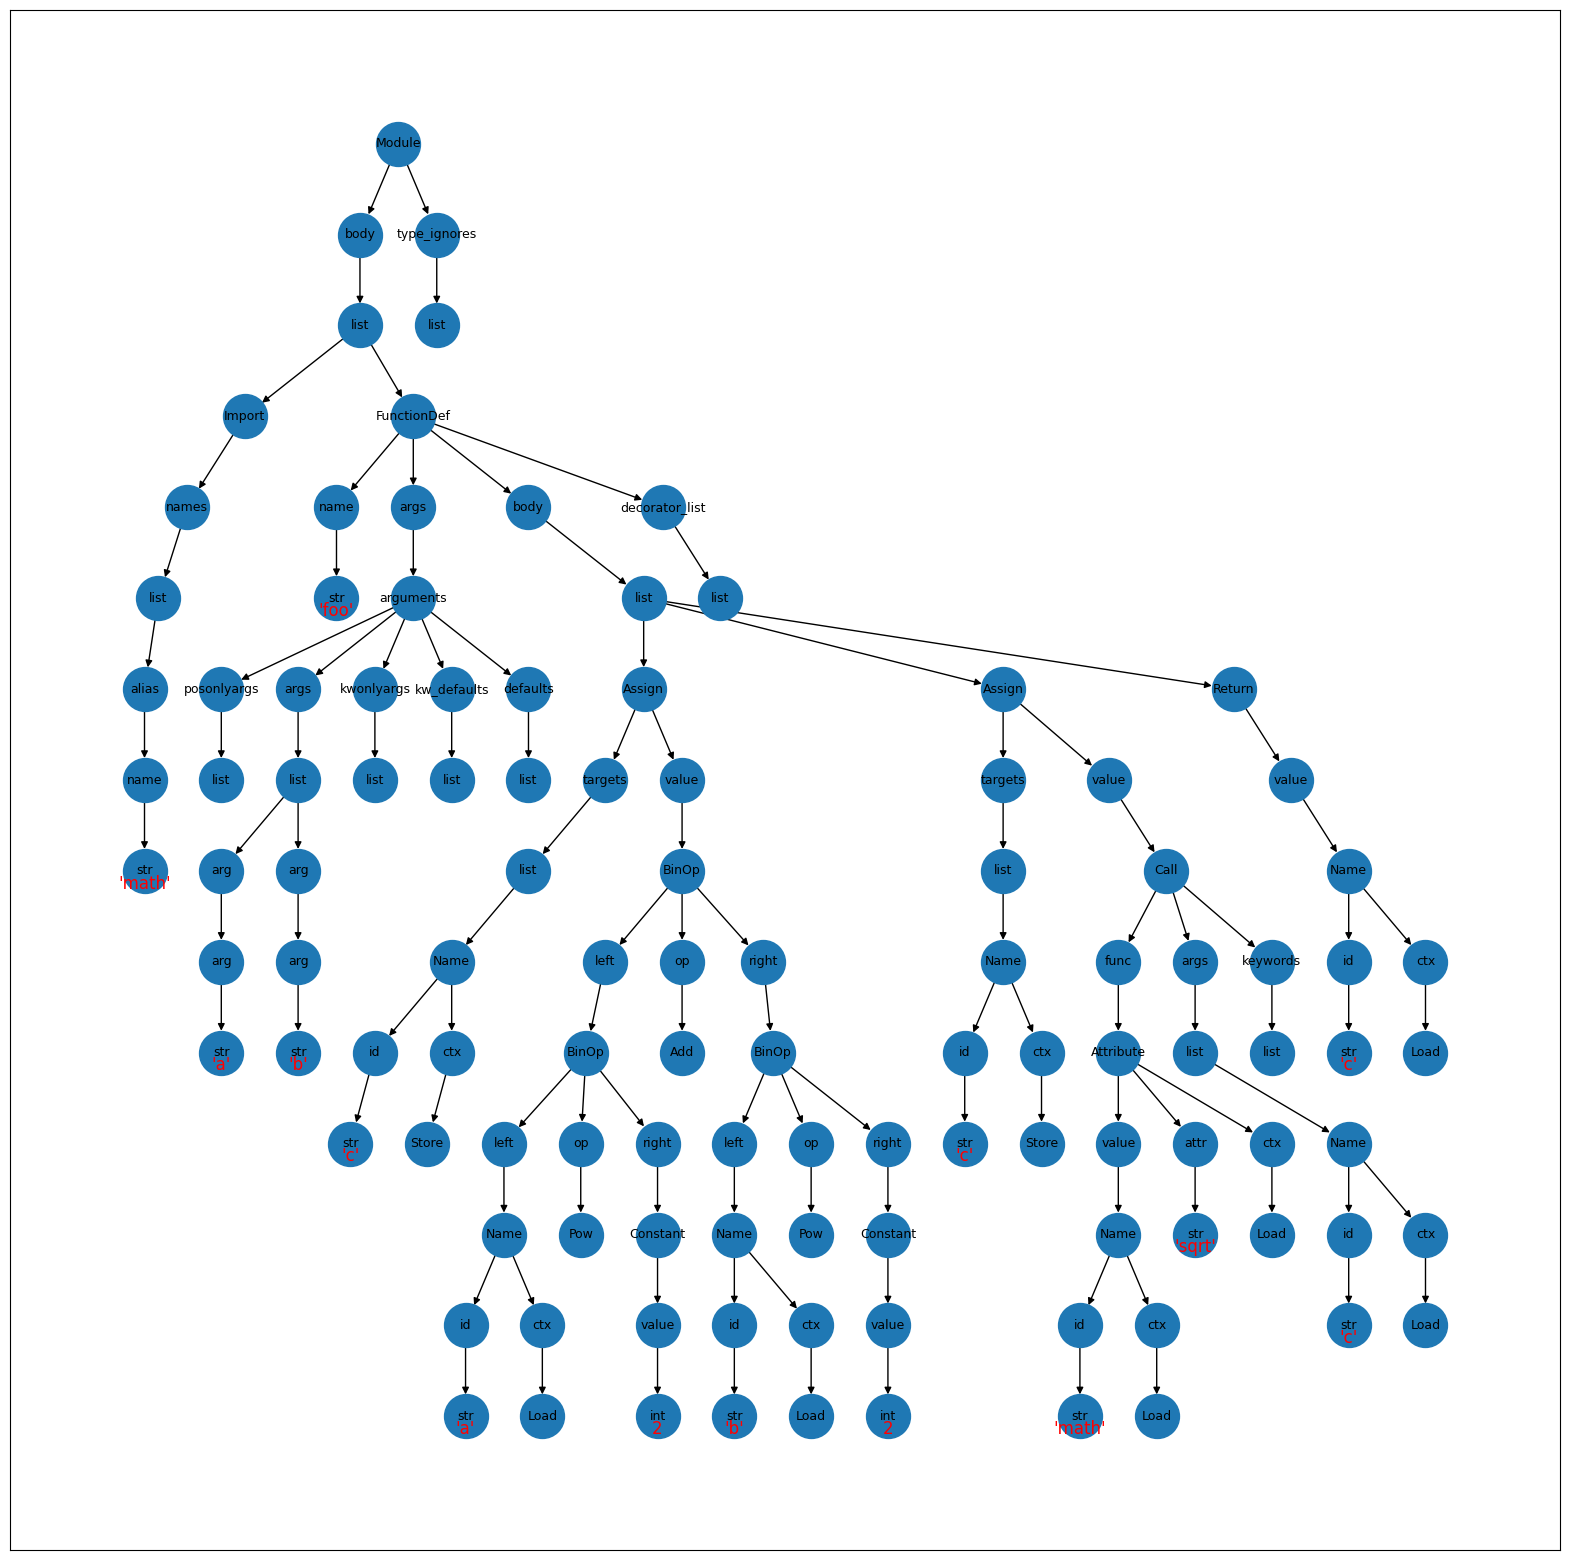

In [27]:

# G = nx.DiGraph()
# add_ast_node_to_graph(G, ast_node)
G, _ = ast_to_graph(ast_node, skip_nulls=False)
type_labels = nx.get_node_attributes(G, "type")
desc_labels = nx.get_node_attributes(G, "desc")
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
state_pos = {n: (x, y-10) for n, (x,y) in pos.items()}


plt.figure(figsize=(20, 20), dpi=100)
nx.draw_networkx(G, pos, labels=type_labels, node_size=1000, font_size=9)
nx.draw_networkx_labels(G, state_pos, labels=desc_labels, font_color='red')

for id in G.nodes:
    print(f"{id}\t{type_labels.get(id, '')}\t{desc_labels.get(id, '')}")
